### Feature(column) Engineer & Regularization

In [5]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [4]:
df = pd.read_csv('../Data/fish.csv')
df.head()

,length,height,width
0,8.4,2.11,1.41
1,13.7,3.53,2.00
2,15.0,3.82,2.43
3,16.2,4.59,2.63
4,17.4,4.59,2.94


In [6]:
# Numpy 변환
fish_full = df.to_numpy()
fish_full[0:6]

array([[ 8.4 ,  2.11,  1.41],
       [13.7 ,  3.53,  2.  ],
       [15.  ,  3.82,  2.43],
       [16.2 ,  4.59,  2.63],
       [17.4 ,  4.59,  2.94],
       [18.  ,  5.22,  3.32]])

In [7]:
df = pd.read_csv('../Data/fish_weight.csv')
df.head()

,weight
0,5.9
1,32.0
2,40.0
3,51.5
4,70.0


In [10]:
fish_weight = df.to_numpy()
fish_weight[0:6]

array([[  5.9],
       [ 32. ],
       [ 40. ],
       [ 51.5],
       [ 70. ],
       [100. ]])

In [13]:
# Train, Test

train_input, test_input, train_target, test_target = train_test_split(fish_full, fish_weight, random_state=42)

### scikit learn 으로 다중회귀 분석하기

In [14]:
from sklearn.preprocessing import PolynomialFeatures 

---
### 다항 특성 만들기 연습 ( *다항* )

In [17]:
poly = PolynomialFeatures()
poly.fit([[2,3]])
print(poly.transform([[2,3]]))

[[1. 2. 3. 4. 6. 9.]]


1:절편 , 2: x, 3:y , 4:x^2, 5:x*y, 6:y^2

In [18]:
# 절편이 필요 없는 경우
poly = PolynomialFeatures(include_bias=False)
poly.fit([[2,3]])
print(poly.transform([[2,3]]))

[[2. 3. 4. 6. 9.]]


In [19]:
train_input.shape

(42, 3)

In [21]:
# train_input의 column이 너무 적어서 늘려야겠어! 하면은 다항 특성 만들기
poly = PolynomialFeatures(include_bias=False)
poly.fit(train_input)
train_poly = poly.transform(train_input)

In [22]:
train_poly.shape
# = (42, 9)
# column이 3 -> 9 로 늘어남 

(42, 9)

In [23]:
train_poly[0:5]

array([[  19.6   ,    5.14  ,    3.04  ,  384.16  ,  100.744 ,   59.584 ,
          26.4196,   15.6256,    9.2416],
       [  22.    ,    5.88  ,    3.52  ,  484.    ,  129.36  ,   77.44  ,
          34.5744,   20.6976,   12.3904],
       [  18.7   ,    5.2   ,    3.12  ,  349.69  ,   97.24  ,   58.344 ,
          27.04  ,   16.224 ,    9.7344],
       [  17.4   ,    4.59  ,    2.94  ,  302.76  ,   79.866 ,   51.156 ,
          21.0681,   13.4946,    8.6436],
       [  36.    ,   10.61  ,    6.74  , 1296.    ,  381.96  ,  242.64  ,
         112.5721,   71.5114,   45.4276]])

In [51]:
# column 정보 확인하기
poly.get_feature_names()


AttributeError: 'PolynomialFeatures' object has no attribute 'get_feature_names'

In [26]:
# test_input을 다항 특성으로 만들기
test_poly = poly.transform(test_input)

test_poly.shape

(14, 9)

---
### 다중 회귀 모델 훈련하기

In [27]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(train_poly, train_target)
print("Train score :", lr.score(train_poly, train_target))
print("Test score :", lr.score(test_poly, test_target))

Train score : 0.9903183436982125
Test score : 0.9714559911594168


오 99 조금만 더 하면 100 만들겠는데 ?
---
### 더 많은 특성을 만들자

In [28]:
poly = PolynomialFeatures(degree=5, include_bias=False)
poly.fit(train_input)
train_poly = poly.transform(train_input)
test_poly = poly.transform(test_input)

In [31]:
train_poly.shape
#(42, 55) 와우... 컬럼이 55개 ..    

(42, 55)

In [37]:
train_poly.get_feature_names()

AttributeError: 'numpy.ndarray' object has no attribute 'get_feature_names'

In [34]:
lr = LinearRegression()
lr.fit(train_poly, train_target)
print("Train score :", lr.score(train_poly, train_target))
print("Test score :", lr.score(test_poly, test_target))

Train score : 0.9999999999989608
Test score : -144.40490464808016


짜잔 ..... ?!? 점수가 - ...?도 나오네 ..? 아주 제대로 된 과대적합 
규제를 해야겠고만

### 규제 전에 표준화
: 표준점수 (Z점수)를 사용

In [35]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(train_poly)

train_scaled = ss.transform(train_poly)
test_scaled = ss.transform(test_poly)

In [36]:
train_scaled.shape
# = (42, 55)

(42, 55)

### Ridge(L2규제) 회귀
: 가중치의 제곱으로 규제하는 방법

In [38]:
from sklearn.linear_model import Ridge

ridge = Ridge() # default : alpha = 1
ridge.fit(train_scaled, train_target)
print("Train score :", ridge.score(train_scaled, train_target))
print("Test score :", ridge.score(test_scaled, test_target))

Train score : 0.9896101671037343
Test score : 0.9790693977615388


### 적절한 규제 강도( Hyper parameter) 찾기

In [39]:
train_score = []
test_score = []

alpha_list =[0.001, 0.01, 0.1, 1, 10, 100]
for alpha in alpha_list:
    ridge = Ridge(alpha=alpha)
    ridge.fit(train_scaled, train_target)
    train_score.append(ridge.score(train_scaled, train_target))
    test_score.append(ridge.score(test_scaled, test_target))
    

In [41]:
train_score

[0.9930455252088416,
 0.9917809981250488,
 0.9903815817570366,
 0.9896101671037343,
 0.988728468997471,
 0.9841843235774494]

In [42]:
test_score

[0.9569388961502774,
 0.9800187936871717,
 0.9827976465386955,
 0.9790693977615388,
 0.9725329582461568,
 0.9627042641050291]

In [43]:
# 구해놓은걸 시각화 하기
import matplotlib.pyplot as plt

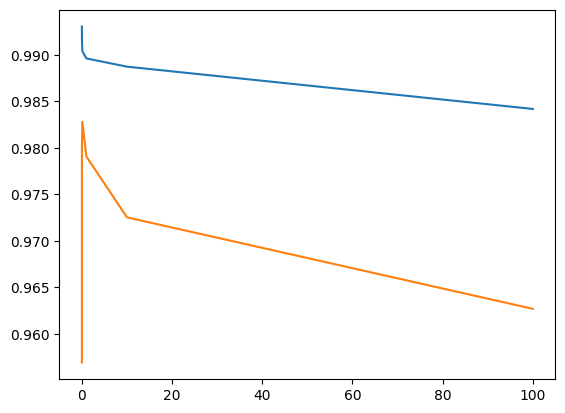

In [50]:
plt.plot(alpha_list, train_score)
plt.plot(alpha_list, test_score)

10 이하는 어느녀석껀지 그래프로 볼수가 읍네 

> x축의 데이터 범위가 너무 커서 소수인 경우에는 확인 할 수 없음

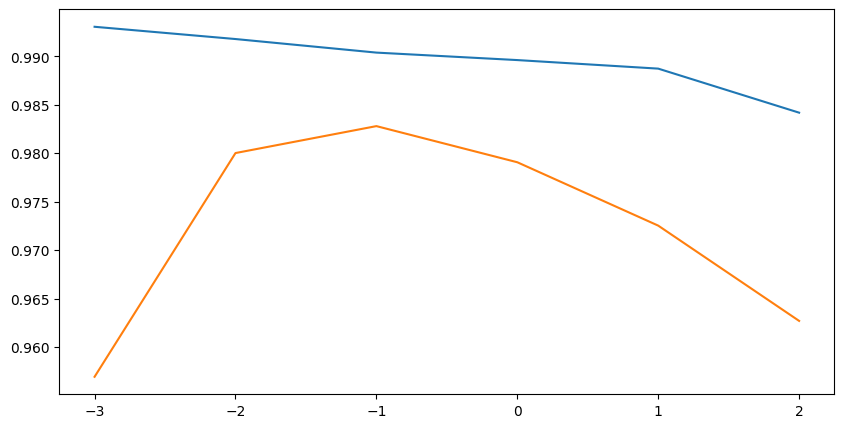

In [46]:
plt.figure(figsize=(10,5))
plt.plot(np.log10(alpha_list), train_score)
plt.plot(np.log10(alpha_list), test_score)
plt.show()

alpha가 -1 인 경우가 train과 test가 제일 가깝다 <- 골디락스(Goldilocks) # 뜨겁지도 차갑지도 않은 지점
-1 은 0.1 이다 

In [49]:

ridge = Ridge(alpha=0.1) # default : alpha = 1
ridge.fit(train_scaled, train_target)
print("Train score :", ridge.score(train_scaled, train_target))
print("Test score :", ridge.score(test_scaled, test_target))

Train score : 0.9903815817570366
Test score : 0.9827976465386955
